# Import packages

In [1]:
%reset 
%cd /Users/yuyuan/Desktop/Work/CMDM_Lab/COVID19_Proj_toGitHub
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import FactorAnalysis, PCA
from sklearn.preprocessing import StandardScaler
from sklearn import manifold

/Users/yuyuan/Desktop/Work/CMDM_Lab/COVID19_Proj_toGitHub


# Main

## Read data

In [14]:
df = pd.read_csv('Data/metadata/md_tidydata/ComparisonOfVariants_wMutual_numeric.csv')
df.head()

,ID,variants,variants_target,RMSD_mutual (0-10ns),RMSD_mutual (10-20ns),RMSD_mutual (20-30ns),RMSD_mutual (30-40ns),RMSD_mutual (40-50ns),RMSD_mutual (50-60ns),RMSD_mutual (60-70ns),...,RMSF_hACE2_pos606,RMSF_hACE2_pos607,RMSF_hACE2_pos608,RMSF_hACE2_pos609,RMSF_hACE2_pos610,RMSF_hACE2_pos611,RMSF_hACE2_pos612,RMSF_hACE2_pos613,RMSF_hACE2_pos614,RMSF_hACE2_pos615
0,1,WT_6m0j,WT,0.419976,0.506053,0.578538,0.553531,0.597366,0.649758,0.640581,...,0.1009,0.1306,0.1412,0.2469,0.1431,0.1686,0.1711,0.5003,0.5072,0.7665
1,2,alpha_6m0j,alpha,0.311318,0.462718,0.445034,0.425279,0.441989,0.478736,0.508923,...,0.1326,0.1317,0.1255,0.2211,0.1308,0.1779,0.1648,0.5153,0.5401,0.7203
2,3,beta_6m0j,beta,0.385116,0.539016,0.539778,0.549066,0.567390,0.629128,0.590386,...,0.1407,0.1553,0.1852,0.2551,0.2111,0.2170,0.2214,0.3599,0.3423,0.5128
3,4,gamma_6m0j,gamma,0.308457,0.366819,0.391369,0.406107,0.434946,0.454904,0.476618,...,0.0888,0.1137,0.1202,0.2011,0.1268,0.1540,0.1482,0.2453,0.3086,0.4995
4,5,delta_6m0j,delta,0.310871,0.468624,0.435889,0.474696,0.625436,0.734920,0.688513,...,0.1134,0.1295,0.1429,0.2557,0.2389,0.2293,0.2202,0.4360,0.4511,0.6266


## Processing

In [15]:
# df_omicron
df_clean_withOmicron = df.dropna(axis=1)
df_clean_withOmicron = df_clean_withOmicron.drop(columns=['ID', 'variants', 'variants_target'])
df_clean_withOmicron = (df_clean_withOmicron-df_clean_withOmicron.mean())/df_clean_withOmicron.std() #normailized

# df_clean: without omicron
df_dropOmicron = df[df['variants_target'] != 'omicron']
df_clean = df_dropOmicron.dropna(axis=1)
df_clean = df_clean.drop(columns=['ID', 'variants', 'variants_target']); df_clean_old = df_clean.copy()

# df_clean_RMSF
df_clean_RMSF = df_clean.filter(regex = "^RMSF")
df_clean_RMSF = (df_clean_RMSF-df_clean_RMSF.mean())/df_clean_RMSF.std() # normailized

# df_clean_noRMSF
df_clean_noRMSF = df_clean.drop(columns = df_clean.filter(regex='^RMSF').columns)
df_clean_noRMSF = (df_clean_noRMSF-df_clean_noRMSF.mean())/df_clean_noRMSF.std() # normailized

# df_clean
df_clean = pd.concat([df_clean_noRMSF, df_clean_RMSF], axis = 1) # merge



## Parameters

In [16]:
variants_target = df_dropOmicron['variants_target']
variants_target_withOmicron = df['variants_target']
colors = {
    'WT':'#adadad', 
    'alpha':'#1f77b4', 
    'beta':'#ff7f0e', 
    'gamma':'#2ca02c', 
    'delta':'#d62728', 
    'deltaplus':'#d48585', 
    'epsilon':'#9467bd', 
    'lambda':'#8c564b',
    'mu':'#e377c2'
}
n_components = 2

## PCA/tSNE Plotting class

In [17]:
class MyPlot:
    def __init__(self, data, colors):    
        self.data = data
        self.colors = colors
        
    def return_ax(self, ax, title=""):
        for target_name in self.colors.keys():
            ax.scatter(self.data[variants_target == target_name, 0], self.data[variants_target == target_name, 1],
                        color=colors[target_name], lw=2, label=target_name)
        ax.legend(loc="best", shadow=False, scatterpoints=1)
        ax.set_title(title)
        return ax

    def quick(self):
        plt.figure(figsize=(8, 8))
        for target_name in self.colors.keys():
            plt.scatter(self.data[variants_target == target_name, 0], self.data[variants_target == target_name, 1],
                        color=colors[target_name], lw=2, label=target_name)
        plt.legend(loc="best", shadow=False, scatterpoints=1)
        #plt.axis([-4, 4, -1.5, 1.5])
        plt.show()

## PCA

<function matplotlib.pyplot.show(close=None, block=None)>

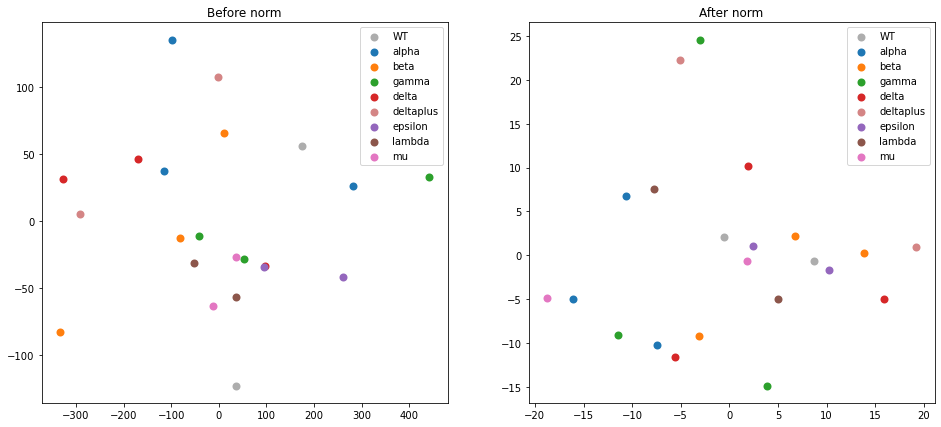

In [18]:
fig, axes = plt.subplots(1,2, figsize = [16, 7])
for data, ax, title in zip([df_clean_old, df_clean], axes, ['Before norm', 'After norm']):
    pca = PCA(n_components=n_components)
    df_pca = pca.fit_transform(data)
    ax = MyPlot(df_pca, colors).return_ax(ax, title)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

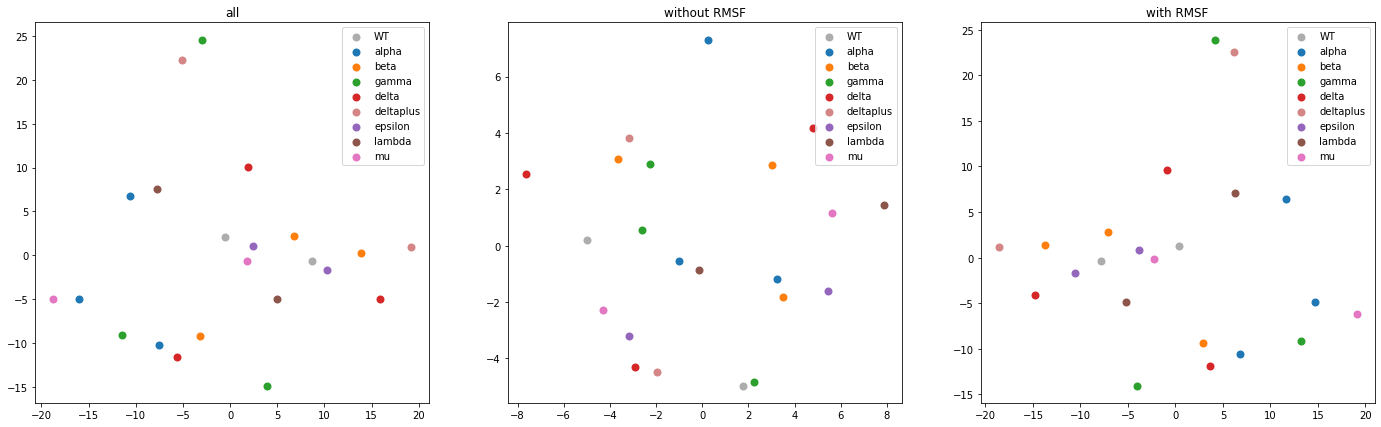

In [19]:
fig, axes = plt.subplots(1,3, figsize = [24, 7])
for data, ax, title in zip([df_clean, df_clean_noRMSF, df_clean_RMSF], axes, ["all", "without RMSF", "with RMSF"]):
    pca = PCA(n_components=n_components)
    df_pca = pca.fit_transform(data)
    ax = MyPlot(df_pca, colors).return_ax(ax, title)
plt.show

## t-SNE

<function matplotlib.pyplot.show(close=None, block=None)>

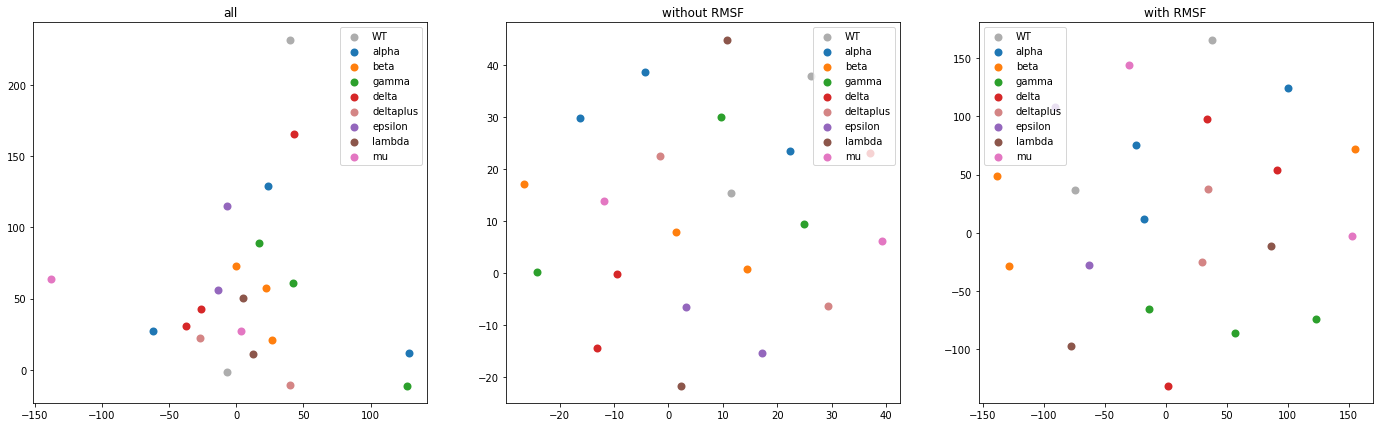

In [20]:
fig, axes = plt.subplots(1,3, figsize = [24, 7])
for data, ax, title in zip([df_clean, df_clean_noRMSF, df_clean_RMSF], axes, ["all", "without RMSF", "with RMSF"]):
    df_tsne = manifold.TSNE(n_components = n_components).fit_transform(df_clean)
    ax = MyPlot(df_tsne, colors).return_ax(ax,title)
plt.show


## PCA Factor Analysis

### CorrPlot class

In [21]:
class CorrPlot():
    def __init__(self, df_clean) -> None:
        self.X = df_clean
    def quick(self, RandPickFeatures = None):
        try:
            features_show = [random.randrange(0,len(self.X.columns),1) for num in range(RandPickFeatures)] #random select 10 features to show
        except:
            features_show = [num for num in range(len(self.X.columns))]
        feature_names = [self.X.columns[i] for i in features_show]
        plt.figure(figsize = [12, 12])
        ax = plt.axes()

        im = ax.imshow(np.corrcoef(self.X.T), cmap="RdBu_r", vmin=-1, vmax=1)

        ax.set_xticks(features_show)
        ax.set_xticklabels(feature_names, rotation=90)
        ax.set_yticks(features_show)
        ax.set_yticklabels(feature_names)

        plt.colorbar(im).ax.set_ylabel("$r$", rotation=0)
        ax.set_title("MD features correlation matrix")
        plt.tight_layout()
    
    def return_ax(self, ax , title, RandPickFeatures = None):
        try:
            features_show = [random.randrange(0,len(self.X.columns),1) for num in range(RandPickFeatures)] #random select 10 features to show
        except:
            features_show = [num for num in range(len(self.X.columns))]
        feature_names = [self.X.columns[i] for i in features_show]
        

        im = ax.imshow(np.corrcoef(self.X.T), cmap="RdBu_r", vmin=-1, vmax=1)

        ax.set_xticks(features_show)
        ax.set_xticklabels(feature_names, rotation=90)
        ax.set_yticks(features_show)
        ax.set_yticklabels(feature_names)

        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='3%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical').ax.set_ylabel("$r$", rotation=0)
        ax.set_title(title)
        fig.tight_layout(pad = 5)
        
        return ax

### Plot

<function matplotlib.pyplot.show(close=None, block=None)>

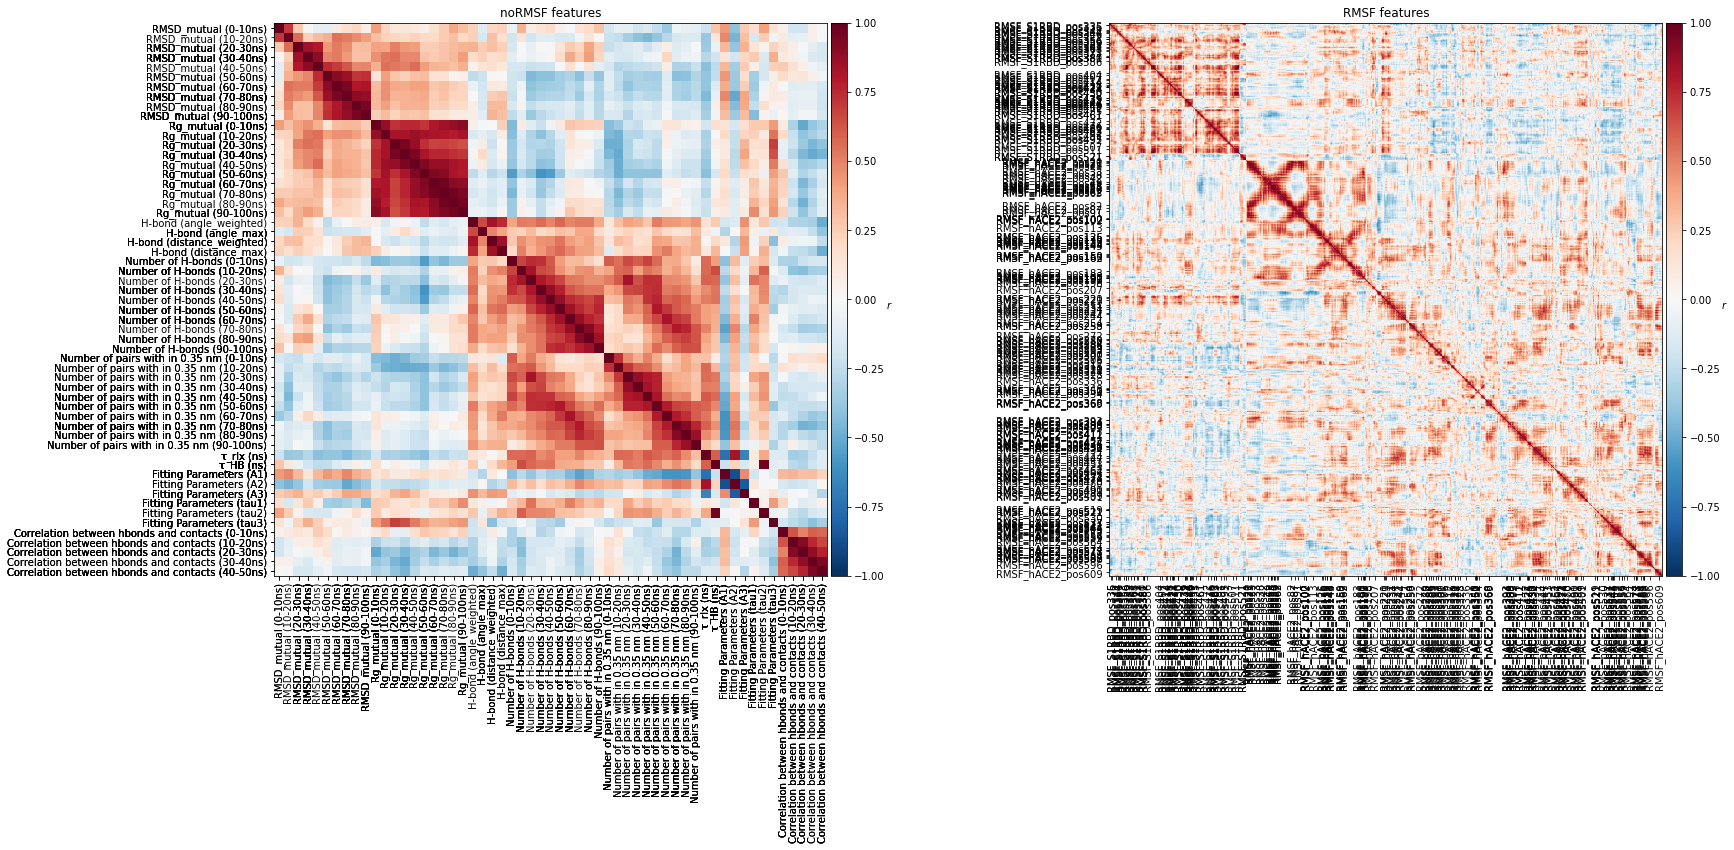

In [22]:
fig, axes = plt.subplots(1,2, figsize = [26, 13])
random.seed(100)
from mpl_toolkits.axes_grid1 import make_axes_locatable

for ax, title, data in zip(axes, ['noRMSF features', 'RMSF features'], [df_clean_noRMSF, df_clean_RMSF]):
    CorrPlot(data).return_ax(ax, title,200)

plt.show

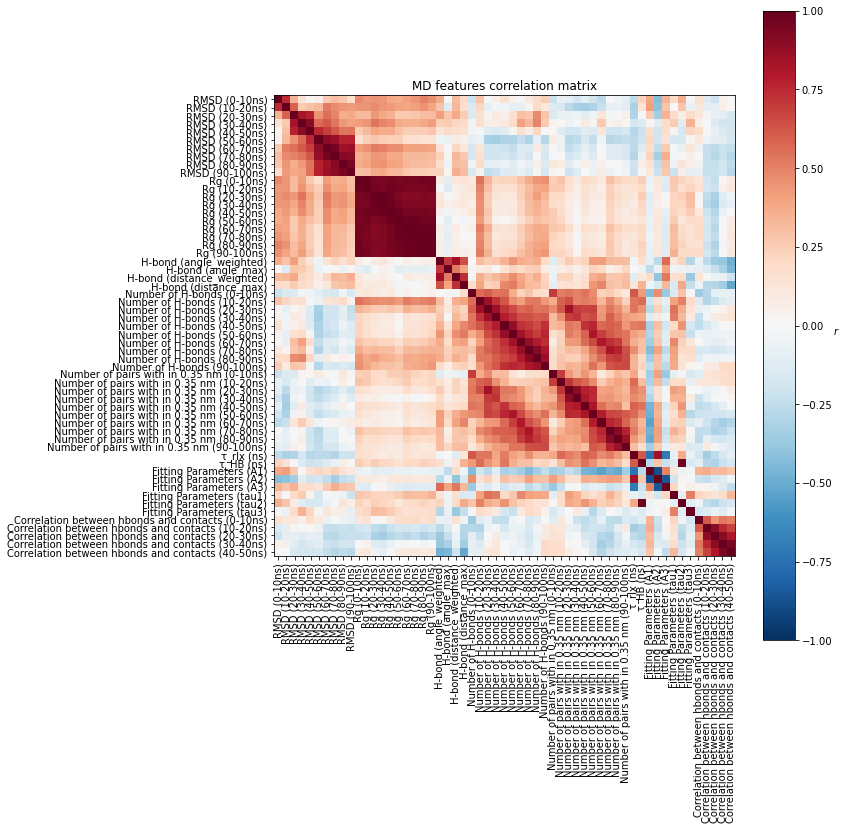

In [11]:
random.seed(100)
CorrPlot(df_clean_withOmicron).quick()

## PCA explainable features



 PCA :

[[ 0.08532309 -0.13079904  0.04643185]
 [ 0.05446602 -0.17589441 -0.0626219 ]
 [ 0.08744613 -0.1293266  -0.19041893]
 [ 0.10797162 -0.12796558 -0.13898609]
 [ 0.0543514  -0.16099835 -0.17341464]
 [ 0.00967458 -0.18389331 -0.14217789]
 [ 0.06310424 -0.21505487 -0.1471379 ]
 [ 0.06608763 -0.20002388 -0.18247705]
 [ 0.07663013 -0.16984336 -0.17692414]
 [ 0.06276242 -0.16865271 -0.1916491 ]
 [ 0.17802801 -0.17238546  0.13286282]
 [ 0.16486056 -0.18965619  0.13059323]
 [ 0.16872648 -0.19299376  0.07896055]
 [ 0.16368498 -0.19642916  0.07515206]
 [ 0.16094845 -0.19616747  0.11803078]
 [ 0.14623133 -0.19840544  0.16111066]
 [ 0.1677944  -0.16907911  0.17324002]
 [ 0.15921338 -0.17639078  0.18246234]
 [ 0.16726495 -0.17185627  0.17671145]
 [ 0.1711631  -0.16691896  0.17100919]
 [ 0.15635095  0.04232409 -0.22250992]
 [ 0.07852436  0.04787902 -0.16301072]
 [ 0.11856447  0.02316184 -0.23412163]
 [ 0.13104352  0.02788751 -0.25811473]
 [ 0.12472124  0.12527609 -0.03138971]
 [ 0.19443263  

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.




 Varimax FA :

[[ 0.5177946   0.04975906  0.03224619]
 [ 0.4082558   0.34469162 -0.11738099]
 [ 0.25429535  0.46160836  0.11792281]
 [ 0.33699906  0.50405093  0.16114174]
 [ 0.24433554  0.62440833 -0.04794045]
 [ 0.16727697  0.84048469 -0.24034809]
 [ 0.3846492   0.85736986 -0.154422  ]
 [ 0.322743    0.90131431 -0.09473716]
 [ 0.27939279  0.86265412 -0.00314489]
 [ 0.24511311  0.86213091 -0.04407425]
 [ 0.93099051  0.16464587  0.14105798]
 [ 0.92640394  0.21240298  0.06931196]
 [ 0.89134886  0.26153153  0.07573174]
 [ 0.90346226  0.23995353  0.04508407]
 [ 0.94002204  0.19145395  0.02674229]
 [ 0.95532346  0.15193338 -0.04220497]
 [ 0.96048115  0.08247091  0.0792243 ]
 [ 0.9685166   0.06098725  0.04374824]
 [ 0.96537888  0.06003675  0.08680489]
 [ 0.96000904  0.06323946  0.11269543]
 [ 0.10825835  0.15850032  0.61015718]
 [-0.00846981 -0.00299807  0.32732822]
 [ 0.02200612  0.3109756   0.51626937]
 [ 0.01518241  0.32704888  0.56586816]
 [-0.05315492  0.06583476  0.63076111]
 [ 0.365

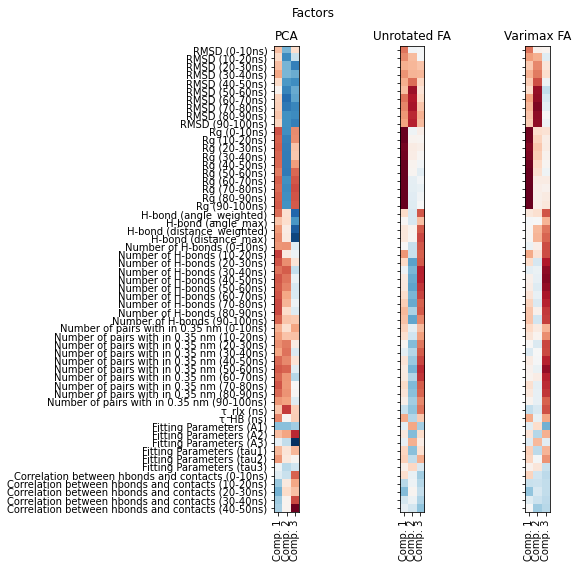

In [32]:
n_comps = 3

methods = [('PCA', PCA()),
           ('Unrotated FA', FactorAnalysis()),
           ('Varimax FA', FactorAnalysis(rotation='varimax'))]
fig, axes = plt.subplots(ncols=len(methods), figsize=(10, 8))

X = df_clean_noRMSF
feature_names = X.columns
for ax, (method, fa) in zip(axes, methods):
    fa.set_params(n_components=n_comps)
    fa.fit(X)

    components = fa.components_.T
    print("\n\n %s :\n" % method)
    print(components)

    vmax = np.abs(components).max()
    ax.imshow(components, cmap="RdBu_r", vmax=vmax, vmin=-vmax)
    ax.set_yticks(np.arange(len(feature_names)))
    if ax.is_first_col():
        ax.set_yticklabels(feature_names)
    else:
        ax.set_yticklabels([])
    ax.set_title(str(method))
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(["Comp. 1", "Comp. 2", "Comp. 3"], rotation = 90)
fig.suptitle("Factors")
plt.tight_layout()
plt.show()

## Cluster Map / Heatmap

### All non RMSF features

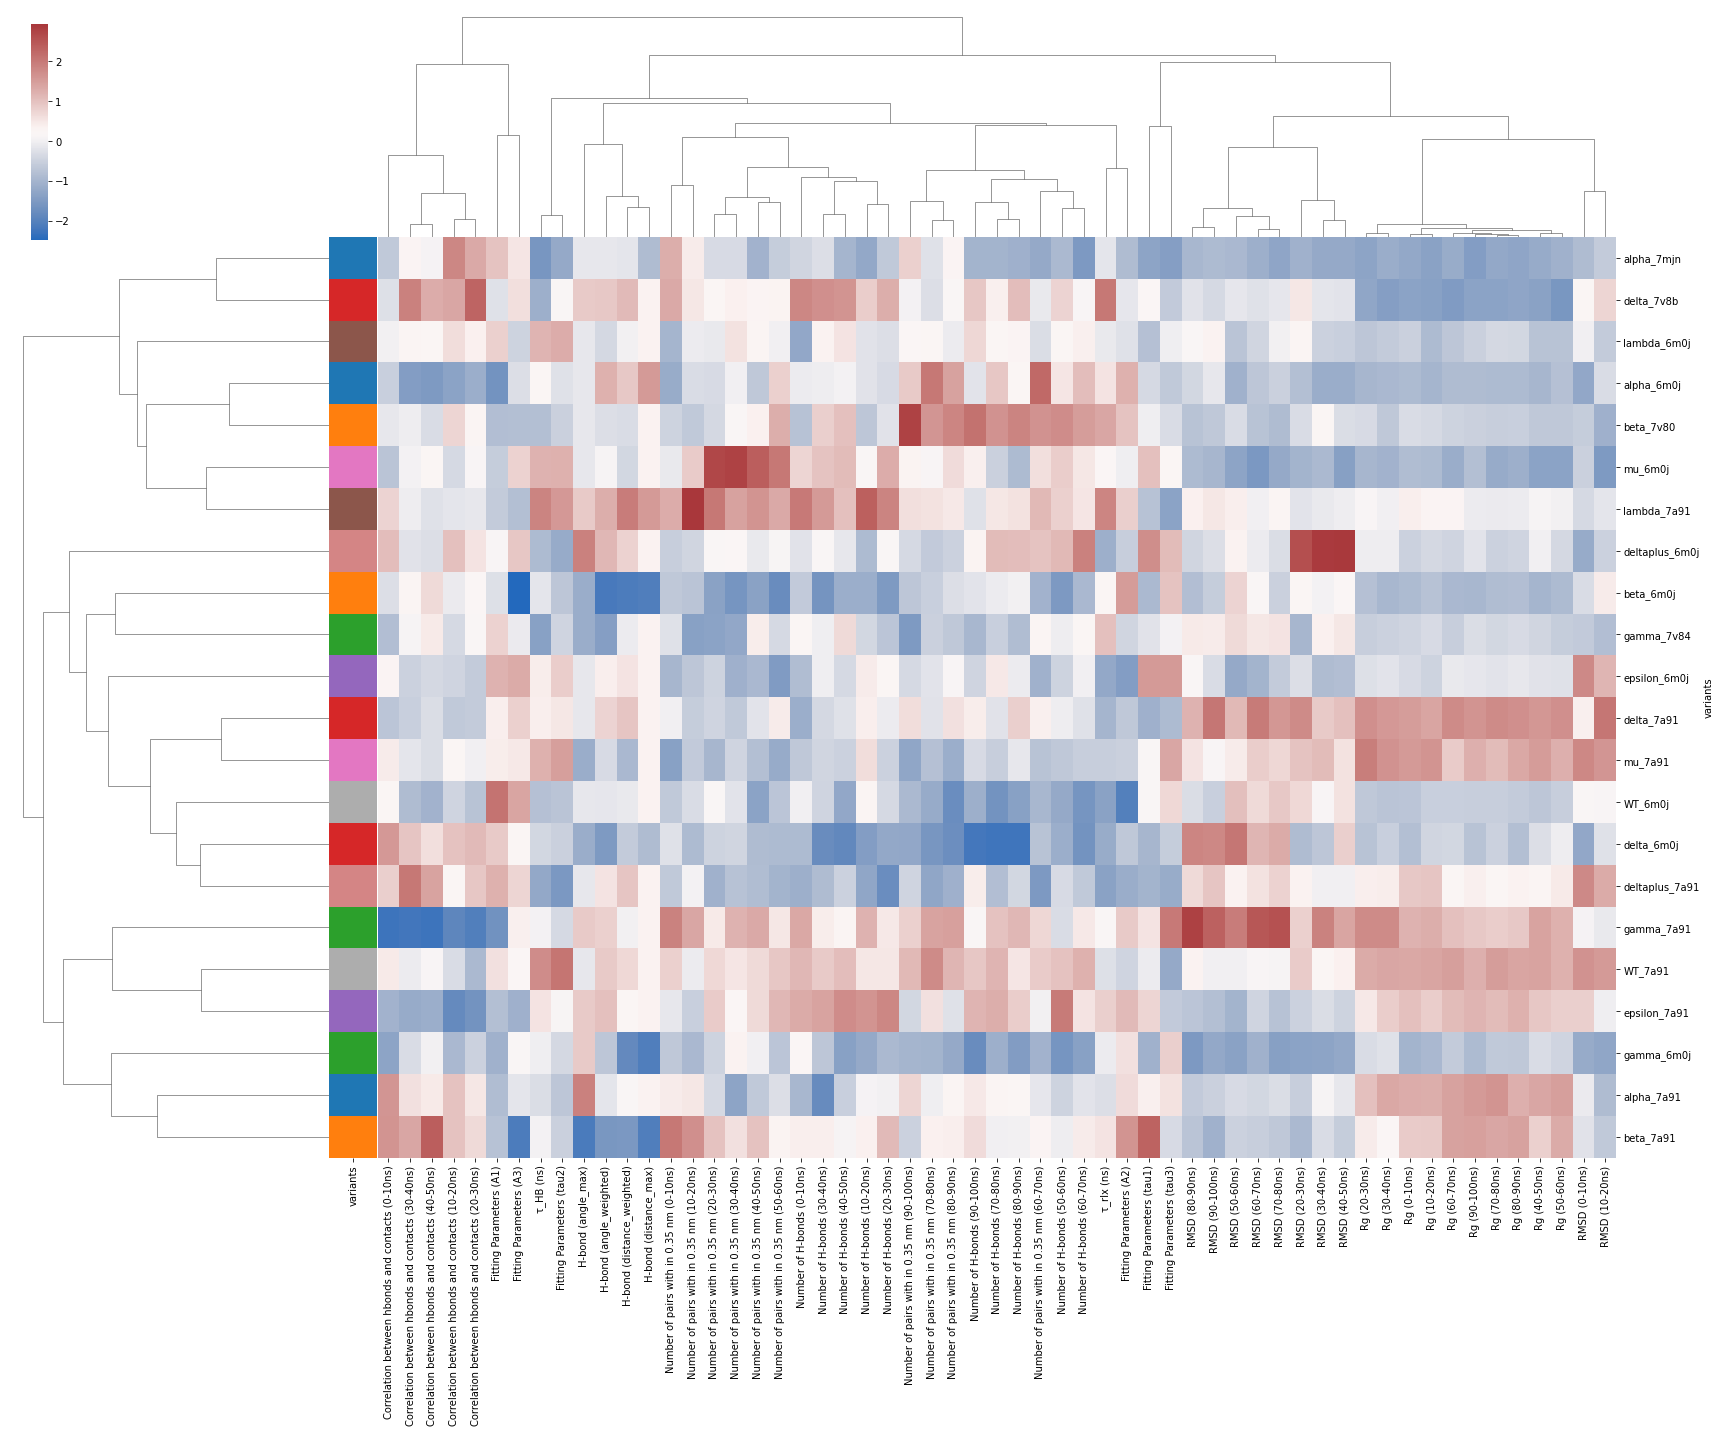

In [33]:
df_clean.index = df_dropOmicron['variants']
df_clean_noRMSF.index = df_dropOmicron['variants']
df_clean_RMSF.index = df_dropOmicron['variants']

variants_type = variants_target.copy()
variants_type.name = 'variants'
row_colors = variants_type.map(colors)
row_colors.index = df_dropOmicron['variants']
sns.clustermap(df_clean_noRMSF, col_cluster=True, metric="correlation", row_colors = row_colors, 
                figsize=(24,20), cbar_pos = [0.02,0.83,0.01,0.15], cmap="vlag")

### Fitting parameters features

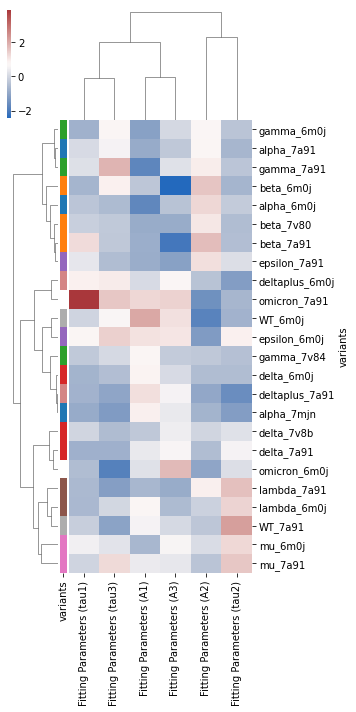

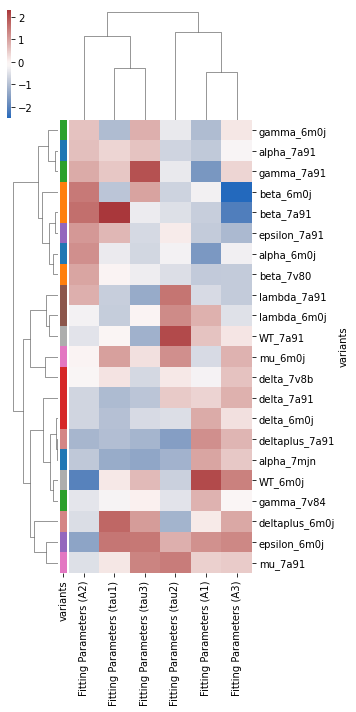

In [34]:
for title, data, rawdata in zip(['with Omicron', 'without Omicron'], [df_clean_withOmicron, df_clean_noRMSF], [df, df_dropOmicron]):
    data = data.filter(regex='Fitting .*')
    data.index = rawdata['variants']
    variants_type = rawdata['variants_target']
    variants_type.name = 'variants'
    row_colors = variants_type.map(colors)
    row_colors.index = rawdata['variants']
    
    sns.clustermap(data, col_cluster=True, metric="correlation", row_colors = row_colors, 
                    figsize=(5,10), cbar_pos = [0.02,0.83,0.01,0.15], cmap="vlag")


### RMSF features

/usr/local/anaconda3/lib/python3.7/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


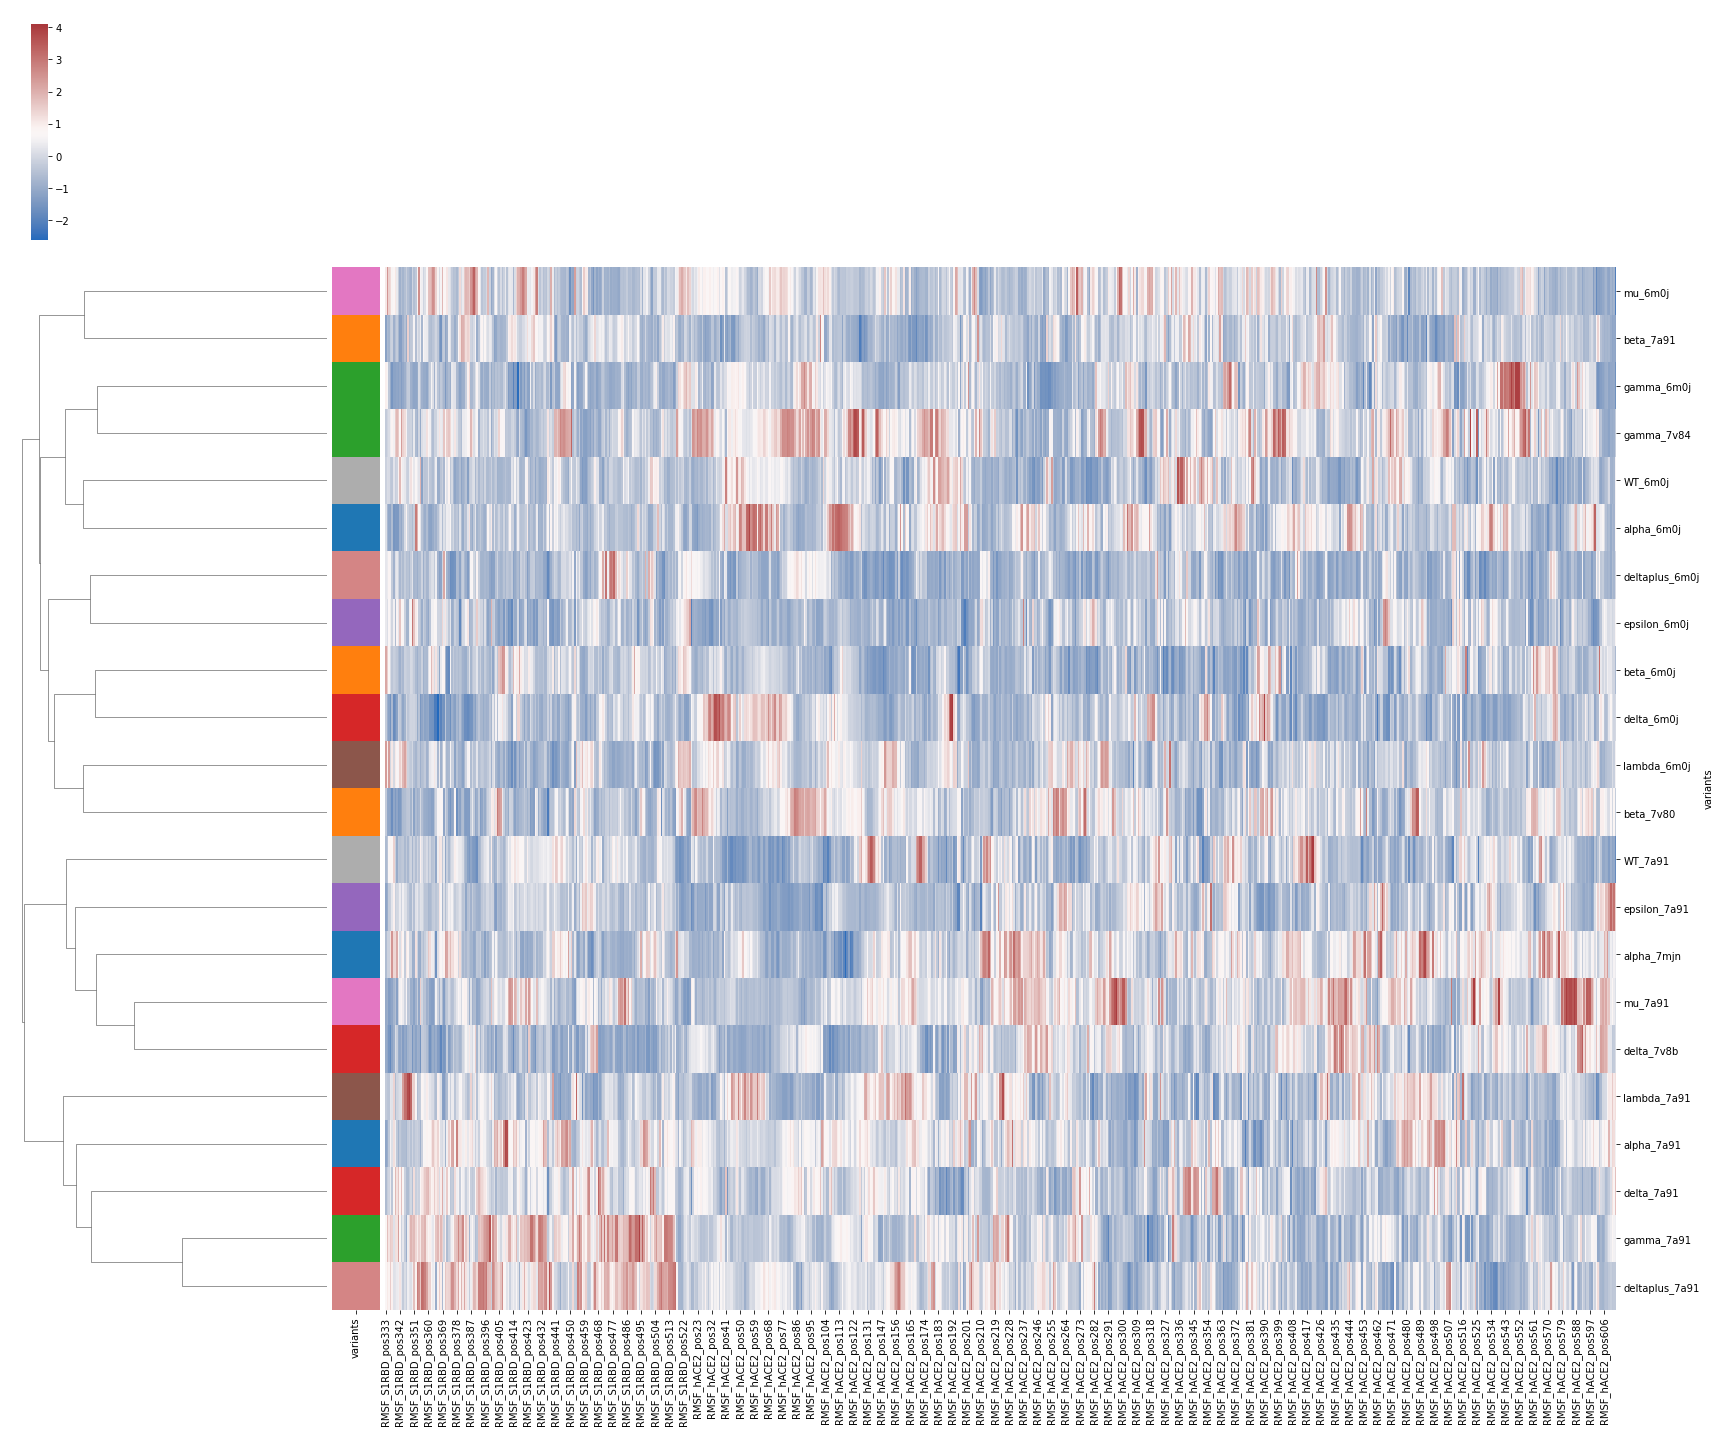

In [35]:
sns.clustermap(df_clean_RMSF, col_cluster=False, metric="correlation", row_colors = row_colors, 
            figsize=[24,20], cbar_pos = [0.02,0.83,0.01,0.15], cmap="vlag")